<a href="https://colab.research.google.com/github/dsaldana/reinforcement-learning-course/blob/main/lab9_mountain_optimal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Predictive Control (MPC) for the Mountain Car

## Exercise 1
In this exercise, you will implement **Model Predictive Control (MPC)** using a **random shooting method** to solve the **Mountain Car** problem.

You will complete the `mpc_action()` function, which chooses the best action sequence by simulating multiple random trajectories into the future and selecting the one with the lowest total cost.

---

## ⚙️ Environment Description
You are working with a **simplified Mountain Car** environment, where the goal is to reach and stay near the top of the right hill (`x ≈ 0.45`).

The car’s state is:
- `x` → position  
- `v` → velocity  

The control input is:
- `u` → engine thrust in the range `[-1, 1]`

The dynamics are defined as:
\[
v_{t+1} = v_t + 0.0015 u_t - 0.0025 \cos(3x_t)
\]
\[
x_{t+1} = x_t + v_{t+1}
\]

---

## 🚀 Task
Your task is to **implement mpc_action function for the MPC controller**.

At each step:
1. You will **sample random sequences of actions** for the next `H` steps.
2. You will **simulate** the effect of each sequence on the system using a provided dynamics model.
3. You will **compute the total cost** of each simulated trajectory.
4. You will **choose the best trajectory** (lowest cost) and apply its first action.

---

## ✅ Deliverables
* The completed mpc_action() function.
* A short report (few paragraphs) answering:
    * How does random shooting choose the best action?
    * How does changing H or N_seq affect the result?
    * Did your car reach and stay near the goal?

In [108]:
%matplotlib inline

# Setup environment and collect initial data

In [175]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------------
# Environment setup
# --------------------------------------------------------------
env = gym.make("MountainCarContinuous-v0", max_episode_steps=2000)

### Dynamics
This is the underneath dynamics in the mountain car. For this exercise, we will use it, but for the following sessions, **we will learn it!**

In [110]:
def mountain_car_dynamics(p, v, a):
    v_next = v + 0.001 * a - 0.0025 * np.cos(3 * p)
    v_next = np.clip(v_next, -0.07, 0.07)
    p_next = p + v_next
    if p_next < -1.2:
        p_next, v_next = -1.2, 0.0
    return np.array([p_next, v_next])

# Test dynamics, at position p, and velocity v, predict the new location when the action a=1 is applied.
mountain_car_dynamics(p=-0.5, v=0, a=1.0)

array([-0.49917684,  0.00082316])

### Cost function

In [111]:
def cost_fn(state, a):
    x, v = state
    goal = 0.5
    target = goal - x

    # Encourage moving in the right direction and gaining kinetic energy
    cost = target**2 - 1000 * np.abs(v)
    return cost

## Roll out trajectories based on action sequences U

In [112]:
def roll_out_trajectory(s0, Ui, gamma=1.0):
    s = s0.copy()  # Initial state
    traj = [s0.copy()]  # Trajectory
    H = len(Ui)
    discount = 1.0

    total_cost = 0.0

    # For each time in the planning horizon
    for k in range(H):
        a = Ui[k]  # continuous action in [-1, 1]
        delta_m = np.zeros(2)

        # Predict Δx using both GPs (for Δp, Δv)
        s = mountain_car_dynamics(s[0], s[1], a)
        traj.append(s.copy())

        # Accumulate discounted cost
        total_cost += cost_fn(s, a) * discount
        discount *= gamma
    return np.array(traj), total_cost


def roll_out_n_trajectories(state, U):
    N_seq = len(U)
    J = np.zeros(N_seq)

    # Roll out trajectories and computer their cost
    all_traj = []
    for i in range(N_seq):
        traj, total_cost = roll_out_trajectory(state, U[i])

        J[i] = total_cost
        all_traj.append(np.array(traj))

    return all_traj, J

# Action squence
Ui = np.zeros(3)
traj, J = roll_out_trajectory(np.array([-0.5,0]), Ui)
traj

array([[-5.00000000e-01,  0.00000000e+00],
       [-5.00176843e-01, -1.76843004e-04],
       [-5.00529206e-01, -3.52362983e-04],
       [-5.01054453e-01, -5.25246664e-04]])

In [113]:
def plot_trajectories(state, best_traj):
    plt.figure(figsize=(8, 6))
    for i, traj in enumerate(best_traj):
        plt.plot(traj[:, 0], traj[:, 1], lw=2, alpha=0.8, label=f"Traj {i+1}")
    plt.scatter(state[0], state[1], color='red', s=60, label="Start", zorder=5)
    plt.axvline(0.5, color='gray', ls='--', label='Goal position')
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title(f"Predicted Trajectories (Continuous MPC)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Finding optimal action for MPC (Random Shooting)

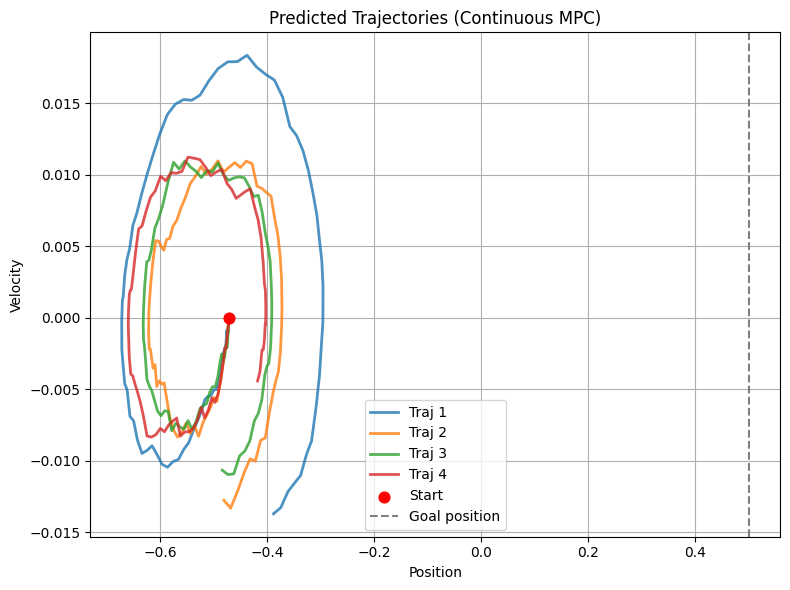

-0.6578343131287061


In [114]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------------------
#  MPC (Random Shooting)
# --------------------------------------------------------------

def mpc_action(state, H=25, N_seq=200, plot=False, plot_best=10, repeat=5):
    """
    Random Shooting MPC for continuous actions in [-1, 1].
    Each GP predicts Δposition and Δvelocity given (pos, vel, action).
    """

    ########### TODO ####################
    # 1. Sample action sequences
    action_sequences = [[np.random.uniform(-1, 1) for i in range(H)] for _ in range(N_seq)]
    # 2. Roll out trajectories
    all_traj, costs = roll_out_n_trajectories(state, action_sequences)
    # 3. Select top trajectories
    ranked_trajectories = sorted(zip(costs, all_traj, action_sequences), key=lambda x: x[0])

    # Plot the best predicted trajectories
    if plot:
        best_traj = [ranked_trajectories[i][1] for i in range(plot_best)]
        plot_trajectories(state, best_traj)

    # 4. Return the first action of the best sequence
    best_action = ranked_trajectories[0][2][0]
    return best_action


obs, _ = env.reset(seed=0)
a = mpc_action(obs, H=80, N_seq=100, plot=True, plot_best=4)
print(a)


In [115]:
# --------------------------------------------------------------
# Running in the gym environment
# --------------------------------------------------------------
H = 80        # MPC horizon
N_seq = 200   # Number of sampled action sequences
steps = 500   # Max episode length


obs, _ = env.reset()
returns = 0.0
a = 0.0       # initial action

trajectory = []

for t in range(steps):
    # --- 1. Compute optimal action via MPC ---
    a = mpc_action(obs, H=H, N_seq=N_seq)

    if t%10==0:
        print("t=",t, "state=", obs, "a=",a)

    # --- 2. Step environment ---
    next_obs, r, term, trunc, _ = env.step([a])  # continuous env expects array-like
    trajectory.append([obs,a])
    env.render()  # draw each step

    returns += r

    # --- 5. Prepare next step ---
    obs = next_obs
    if term or trunc:
        break

print(f"Episode return: {returns:.2f}")
print("t=",t, "state=", obs, "a=",a)
env.close()


t= 0 state= [-0.5460427  0.       ] a= -0.9327172730633841
t= 10 state= [-0.590887   -0.00794156] a= -0.6489428951603349
t= 20 state= [-0.6637607  -0.00357324] a= -0.2322721318521499
t= 30 state= [-0.6184969   0.01117692] a= -0.7973700610655943
t= 40 state= [-0.47177568  0.01658517] a= 0.4255409891555264
t= 50 state= [-0.32637995  0.01041305] a= 0.9850754253876526
t= 60 state= [-0.2790207  -0.00354111] a= 0.6937691079457771
t= 70 state= [-0.40813035 -0.02131158] a= -0.3271712909427231
t= 80 state= [-0.65451616 -0.02372336] a= 0.5767153573041268
t= 90 state= [-0.82671374 -0.01424746] a= 0.4171845562042522
t= 100 state= [-0.8427097   0.00730471] a= 0.9816394490657563
t= 110 state= [-0.6241002   0.03281474] a= 0.7835729051417906
t= 120 state= [-0.27848744  0.03315708] a= 0.8947519508138426
t= 130 state= [-0.03190936  0.0138032 ] a= 0.5724937614103658
t= 140 state= [-0.01345207 -0.01079734] a= -0.6202751866321601
t= 150 state= [-0.25389534 -0.03260568] a= -0.8077238707992578
t= 160 state= 

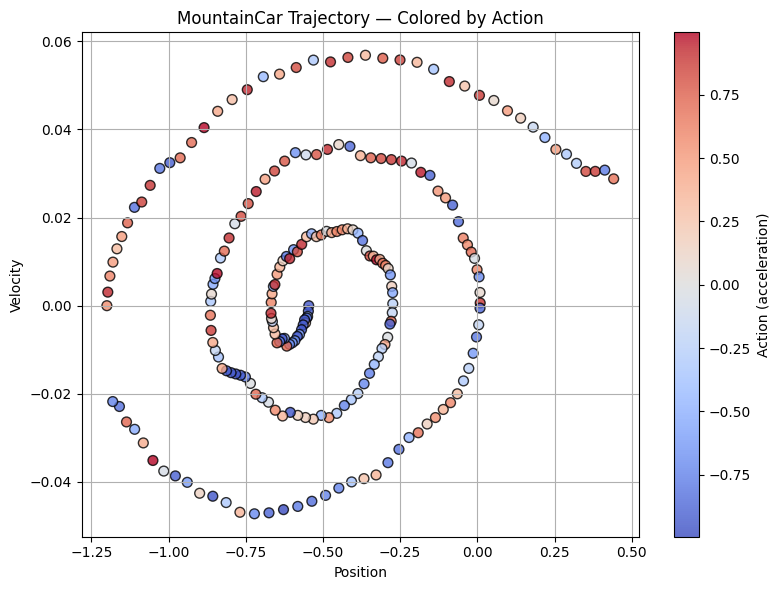

In [116]:
# trajectory is a list of [obs, a]
# each obs is [pos, vel]

def plot_trajectory(trajectory):
    positions, velocities, actions = [], [], []

    for entry in trajectory:
        obs, a = entry
        positions.append(obs[0])
        velocities.append(obs[1])
        actions.append(float(a))  # ensure scalar

    positions = np.array(positions)
    velocities = np.array(velocities)
    actions = np.array(actions)

    # --------------------------------------------------------------
    # Scatter plot: position vs velocity, colored by action
    # --------------------------------------------------------------
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(positions, velocities, c=actions,
                     cmap='coolwarm', s=50, edgecolor='k', alpha=0.8)

    cbar = plt.colorbar(sc, label="Action (acceleration)")
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title("MountainCar Trajectory — Colored by Action")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_trajectory(trajectory)

In [117]:
trajectory[-1]

[array([0.44162312, 0.02878648], dtype=float32), 0.6739205012354343]

### Discussion:
In the random shooting method, the agent samples a set of random action sequences for a fixed horizon H. Each sequence is simulated forward from the current state using the environment’s dynamics, and the total cumulative reward for each trajectory is computed. The algorithm then ranks all trajectories by their total return and selects the first action from the highest-return sequence to execute in the real environment. This process is repeated at each time step, forming a simple form of model predictive control (MPC).

The two main hyperparameters—planning horizon (H) and number of sampled sequences (N_seq)—directly affect performance and computation. Increasing H allows the agent to look further ahead, capturing the long-term effect of actions (which is important in MountainCar, where the car must first move backward to gain momentum). However, a large H also increases computational cost and can make predictions less accurate if the dynamics model or environment rollout is noisy. Increasing N_seq
provides a denser sampling of possible action sequences, improving the chance of finding a high-reward plan, but again at higher computational cost. In practice, there is a trade-off: small H or N_seq often lead to shortsighted or unstable behavior, while overly large values slow the simulation.



# 🧩 Exercise 2: Implement the MPPI Controller

In this exercise, you will complete the **`action()` method** of the `MPPIController` class.  
This method implements the **Model Predictive Path Integral (MPPI)** algorithm, which selects an optimal control action based on sampled action sequences and their simulated costs.

---

## ⚙️ MPPI Overview

Model Predictive Path Integral (MPPI) control is a **sampling-based model predictive controller**.  
It explores many possible future action sequences and evaluates them under a dynamics model.  
Unlike random shooting, MPPI adds **Gaussian noise around a mean sequence** and keeps track of a **persistent best sequence** that shifts at every step.

At each time step:

1. **Shift** the previous mean action sequence (`U_mean`) forward in time.  
   → This reuses information from the last solution.

2. **Sample** new action sequences by adding Gaussian noise around this mean.

3. **Roll out** each sequence using the system dynamics to compute its total cost.

4. Mean computation:
   * For undergraduate: **Select** the best trajectory (the one with the lowest cost) as the mean. (MPPI Simplified version)
   * For graduate: Compute **importance-weighted averages of control perturbations**, following the path-integral formulation of stochastic optimal control.

6. **Return** the first action of the best sequence to apply to the system.

---
# 🧩 Deliverables

* The completed action() method implementation.

* A short explanation (1–2 paragraphs) describing how your controller selects actions and how it differs from random shooting.

* Questions for Discussion

    * Why does MPPI reuse the previous mean sequence (U_mean)?

    * What would happen if we didn’t shift it each iteration?

    * How does the horizon H affect stability and responsiveness?

    * Compare MPPI to random shooting — what advantage does MPPI bring?


# MPPI

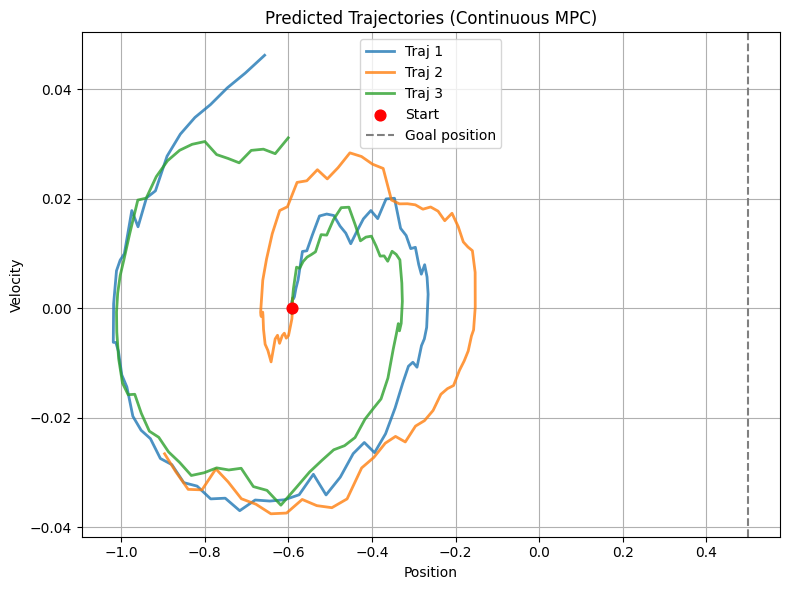

-1.3546054236548204

In [118]:
import numpy as np
import matplotlib.pyplot as plt

class MPPIController:
    def __init__(self, H=100, N_seq=200, λ=1.0, σ=0.3):
        """
        Model Predictive Path Integral Controller with persistent action sequence.
        Uses the best trajectory (lowest-cost) to update instead of weighted mean.
        """
        self.H = H
        self.N_seq = N_seq
        self.λ = λ
        self.σ = σ


        # Persistent mean sequence for warm-start
        self.U_mean = np.zeros(H)

    def action(self, state, plot=False, plot_best=3):
        H, N_seq, σ = self.H, self.N_seq, self.σ

        ######## TODO #############
        # 0 Shift previous mean sequence (reuse previous solution)
        self.U_mean = np.roll(self.U_mean, -1)
        self.U_mean[-1] = 0.0
        # 1. Sample action sequences (Gaussian noise around previous U_mean)
        noise = np.random.normal(0, σ, size=(N_seq, H))
        action_sequences = self.U_mean + noise
        
        # 2. Roll out trajectories
        all_traj, all_cost = roll_out_n_trajectories(state, action_sequences)

        # 4-under-grad. Select the best trajectory (lowest cost)
        ranked_trajectories = sorted(zip(all_cost, all_traj, action_sequences), key=lambda x: x[0])
        # self.U_mean = ranked_trajectories[0][2]

        # 4-grad. Compute weights (importance weights)
        min_cost = np.min(all_cost)
        weights = np.exp(-(all_cost - min_cost) / self.λ)
        weights /= np.sum(weights)
        weighted_noise = np.sum(weights[:, None] * noise, axis=0)
        self.U_mean += weighted_noise


        #  Optional: plot best trajectories
        if plot:
            best_k = np.argsort(all_cost)[:plot_best]
            best_traj = [all_traj[i] for i in best_k]
            plot_trajectories(state, best_traj)
        
        # 5. Return the first action of the best sequence
        best_action = ranked_trajectories[0][2][0]
        return best_action

# Initialize controller once
mppi = MPPIController(H=80, N_seq=150, λ=1.0, σ=2.1)

obs, _ = env.reset()
a = mppi.action(obs, plot=True, plot_best=3)  # plot first iteration only
a

In [119]:
# Initialize controller once
mppi = MPPIController(H=30, N_seq=200, λ=.10, σ=.50)

obs, _ = env.reset(seed=0)
traj = []

for t in range(500):
    a = mppi.action(obs)  # plot first iteration only
    traj.append([obs, a])

    if t%10==0:
      print(t, obs, a)

    obs, r, term, trunc, _ = env.step([a])


    if term or trunc:
        break

print(f"Total time: {t:.0f}")
print(t, obs, a)

0 [-0.47260767  0.        ] -0.3087354636662127
10 [-0.5350708 -0.011475 ] -2.3053378641689144
20 [-0.7069578  -0.01933081] -9.323492987756687
30 [-0.88480073 -0.01495555] 0.38852560135327946
40 [-0.8370285   0.02151644] 8.923776996368035
50 [-0.45773897  0.04774357] 5.460249182712186
60 [0.025728   0.04542498] 6.489077935660429
70 [0.44509804 0.04180879] 4.507134770278089
Total time: 70
70 [0.48782352 0.04272546] 4.507134770278089


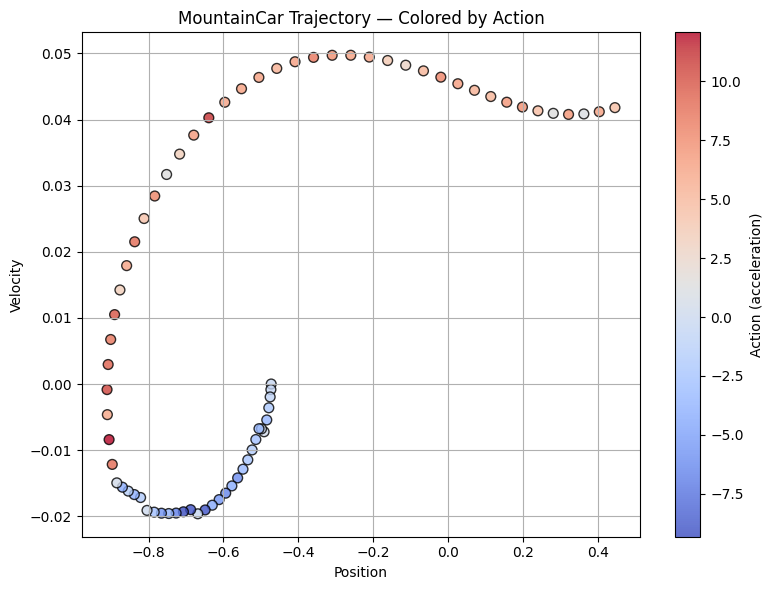

Energy 2460.033930057355


In [120]:
plot_trajectory(traj)

print("Energy", sum([a**2for s,a in traj]))

In [121]:
trajectory[-1]

[array([0.44162312, 0.02878648], dtype=float32), 0.6739205012354343]

### Discussion:
MPPI reuses and shifts the previous mean control sequence to provide a warm start for the next optimization step. Since consecutive time steps are highly correlated in continuous control tasks, the previously optimal action sequence is likely to remain near-optimal for the next step (just one step shifted forward in time). This reuse dramatically improves convergence speed and reduces the number of samples needed, because the controller doesn’t start each iteration from a random guess.

If we didn’t shift U_mean, the controller would lose the temporal continuity between time steps. Each iteration would start from scratch, forcing MPPI to explore blindly and re-learn a good sequence from random noise. This would lead to less stable control, higher variance in the chosen actions, and possibly oscillations or failure to maintain smooth motion, especially in tasks that require consistent force application like MountainCar or cart-pole balancing.

The planning horizon H determines how far into the future MPPI looks when optimizing actions. A larger H allows the controller to account for long-term consequences of actions (important for tasks with delayed rewards), leading to smoother and more stable behavior. However, it also makes the controller less responsive to sudden changes and increases computational cost. A smaller H makes the controller more reactive but can cause short-sighted decisions and instability when long-term planning is needed. Thus, H controls the trade-off between stability and responsiveness.

Random shooting selects only the single best trajectory from a set of random samples, ignoring information from all others. MPPI, in contrast, uses importance-weighted averaging of all sampled trajectories, guided by their exponential cost weighting. This allows MPPI to combine exploration and exploitation more effectively, producing smoother, lower-variance control and faster convergence. Moreover, MPPI’s use of the shifted U_mean provides temporal consistency across iterations, while random shooting re-plans from scratch every step, often resulting in more erratic actions.



# 🧩 Exercise 3: Reward Engineering — Stop at the Goal and Save Energy

In this exercise you will explore **reward shaping** and how it changes robot behavior.  
You will modify the Mountain Car reward so that the robot:
1. **Stops at the goal** rather than overshooting it.  
2. **Uses minimal control effort** (energy efficiency).

The goal is to understand how each term in a reward function influences motion and stability.

---

## ⚙️ Background
In reinforcement learning and model-based control, the reward (or cost) encodes *what* we want the agent to do.  
A poorly designed reward may lead to:
- Unstable or oscillatory behavior  
- Excessive control effort  
- Agents that reach the goal but never stop  

The standard Mountain Car reward only gives a terminal bonus for reaching the goal:
\[
r = 100 \, \mathbf{1}[x \ge 0.45] - 0.1u^2
\]
It encourages reaching the hilltop but does **not** reward *staying there* or *saving energy*.

---

## 🧩 Tasks

### a) Make the robot **stop at the goal**
You will modify the reward so that the agent receives high reward when it is **close to the goal** *and* has **small velocity**.

Implement a new reward function that encourages being near the goal position, and make the car stop once it arrives.  


Test this reward inside your MPC or MPPI loop.  
Observe whether the car reaches the top and remains there.

---

### b) Make the robot **save energy**
Design a second version of the reward that explicitly penalizes energy use more strongly. The energy is proportional to the square of the control input **a**.


Run simulations again and compare:
- Does the car reach the goal more slowly?  
- Does it stop more gently?  
- How much smaller are the average control inputs?

---

## Hint
Take into account that the weights help to scale the magnitude of the variables. For example,

---
# ✅ Deliverables

* Two implemented reward functions:

    * (a) Stop-at-goal

    * (b) Energy-saving

* Position, velocity, and control plots for both cases.

* A short report (≈ 1 paragraph per reward) answering:

    * How did each reward affect the trajectory?

    * Which terms were most influential?

    * Did the car stop smoothly at the goal?


0 [-0.47260767  0.        ] -0.7019370971920674
10 [-0.50145894 -0.00363998] -0.08703631056225561
20 [-0.5392134  -0.00356828] -0.5807294429845096
30 [-0.58427435 -0.00325204] 1.0251826751894668
40 [-0.5850936   0.00275359] -0.30179858075024735
50 [-0.5535919   0.00436603] -0.2637120155842021
60 [-0.4854679   0.00733683] 0.35839231477769823
70 [-0.41799343  0.0062809 ] -0.03570612702201906
80 [-0.40135524 -0.00268851] -0.007444452441497884
90 [-0.47633135 -0.01162043] 0.2841089038650546
100 [-0.5953702  -0.01160577] -0.46607960780159174
110 [-0.6789511  -0.00325597] -0.23382396285469909
120 [-0.65092385  0.00751223] -0.09579263362950896
130 [-0.5304264   0.01565923] 0.7765788677906431
140 [-0.3716168   0.01233967] 0.5957644777802945
150 [-0.29370487  0.00036036] -0.38173993103288034
160 [-0.368258   -0.01481311] 0.4963790754429128
170 [-0.5684809  -0.02488342] -0.09617073785781782
180 [-0.7792185  -0.01355903] -0.4526010578203872
190 [-0.8189553   0.00626686] 0.7786857033178285
200 [-0

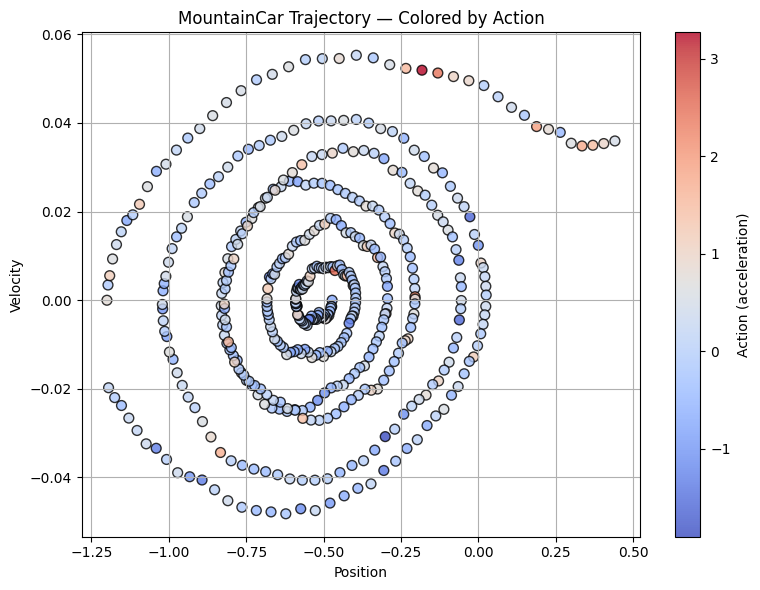

Energy 170.58775248434992


In [147]:
# minimizing the energy

def cost_fn(state, a):
    x, v = state
    goal = 0.5

    w_pos = 8.0
    w_vel = 1000.0
    w_ctrl = 45.0   # much stronger penalty on action (energy)

    pos_err = x - goal
    cost = w_pos * (pos_err ** 2) - w_vel * np.abs(v) + w_ctrl * np.abs(a) 
    return cost

# Initialize controller once
mppi2 = MPPIController(H=30, N_seq=200, λ=.10, σ=.50)

obs, _ = env.reset(seed=0)
traj = []

for t in range(1000):
    a = mppi2.action(obs)  # plot first iteration only
    traj.append([obs, a])

    if t%10==0:
      print(t, obs, a)

    obs, r, term, trunc, _ = env.step([a])


    if term or trunc:
        break

print(f"Total time: {t:.0f}")
print(t, obs, a)
plot_trajectory(traj)

print("Energy", sum([a**2for s,a in traj]))

In [158]:
traj[-1]

[array([0.42444193, 0.02871148], dtype=float32), 5.909498177130194]

## discussion:
I modified the reward and added a term that considers the action. This reward strongly encourages the agent to generate velocity because the negative velocity term (−1000 · |v|) massively reduces cost when the car moves quickly. At the same time, the high control penalty (45 · |a|) pushes the optimizer to build that velocity efficiently, using as few high-magnitude actions as possible.

49 [-0.15446302 -0.00575474] 7.137344325648097
99 [-0.36046183  0.01933276] 7.687342572144123
149 [-0.25322637 -0.01986071] 7.548960299009529
199 [-0.15347047  0.01662825] 5.741165961359283
249 [-0.468073   -0.01636941] 7.073546828154623
299 [-0.00073766  0.00651039] 8.10231066605684
349 [-0.63441193 -0.00181185] 6.266071078367966
399 [0.14595833 0.00025065] 10.38520192775312
449 [-0.71681094 -0.00658507] 6.913430338965851
499 [0.37534344 0.00955351] -0.6896767189852469
549 [ 0.31984758 -0.00180796] 4.248681099617907
599 [ 0.04720682 -0.01726067] 6.481257861162066
649 [-0.4170781   0.03020686] 9.623705952891617
699 [0.3589305  0.00204827] 2.308653107572531
749 [ 0.35930452 -0.00356385] 3.50075699765801
799 [ 0.27414942 -0.00275443] 6.56176909799329
849 [-0.5392313  -0.02466219] 1.8574501750387267
899 [0.1887694  0.01689787] 1.8585641525369787
Total time: 931
931 [0.45199752 0.00340191] 1.2931182805190722


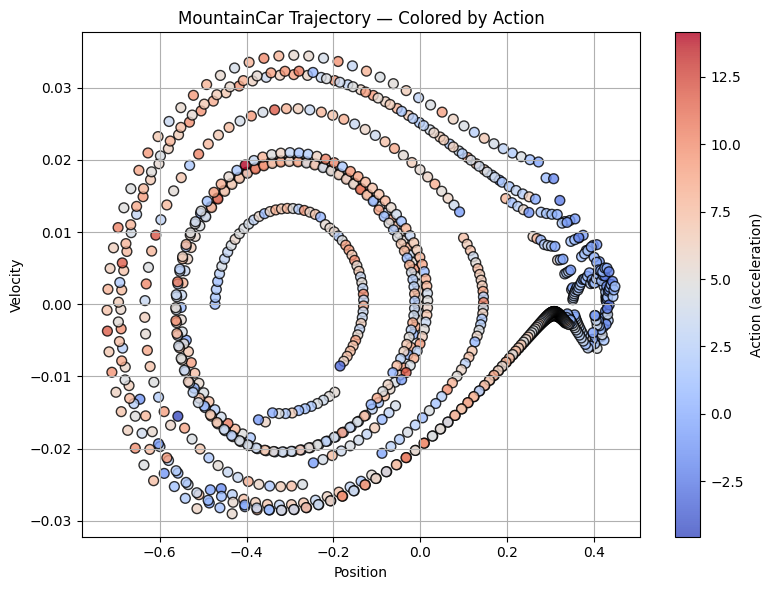

Energy 28309.39673990582


In [180]:
def cost_fn(state, a):
    x, v = state
    goal = 0.5

    w_pos = 8.0
    w_vel = 100.0
    w_ctrl = -0.0   # much stronger penalty on action (energy)

    pos_err = x - goal
    cost = w_pos * (pos_err ** 2) - w_vel * np.abs(v) + w_ctrl * np.abs(a) 
    return cost

# Initialize controller once
mppi2 = MPPIController(H=30, N_seq=200, λ=.10, σ=.50)

obs, _ = env.reset(seed=0)
traj = []

for t in range(1000):
    a = mppi2.action(obs)  # plot first iteration only
    traj.append([obs, a])

    if (t+1)%50==0:
      print(t, obs, a)

    obs, r, term, trunc, _ = env.step([a])


    if term or trunc:
        break

print(f"Total time: {t:.0f}")
print(t, obs, a)
plot_trajectory(traj)

print("Energy", sum([a**2for s,a in traj]))

In [181]:
traj[-1]

[array([0.4485956, 0.0024597], dtype=float32), 1.2931182805190722]